# netCDF File Visualization Case Study

I was asked by a colleague to visualize data contained within this [netCDF file](https://motherlode.ucar.edu/repository/entry/show/RAMADDA/Unidata/Staff/Julien+Chastang/netcdf-explore?entryid=c7239224-d3fe-45d8-b100-43ae043824c3) ([OPeNDAP link](https://motherlode.ucar.edu/repository/opendap/41f2b38a-4e70-4135-8ff8-dbf3d1dcbfc1/entry.das)) with Python. What follows is an exploration of how I achieved that objective. Because this exercise touches upon many technologies related to Unidata, I want to share this notebook with the community. We will be meandering through,

- netCDF
- WMO GRIB metadata
- Map projections
- netcdf4-python
- cartopy

To get our bearings let's first see what there is inside our netCDF file.

In [1]:
import xray
import cartopy.crs as ccrs

# Set-up for notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
ds = xray.open_dataset('https://motherlode.ucar.edu/repository/opendap/41f2b38a-4e70-4135-8ff8-dbf3d1dcbfc1/entry.das', decode_times=False)
print(ds)

<xray.Dataset>
Dimensions:         (nav: 1, record: 1, x: 1901, y: 1801, z: 1)
Coordinates:
  * z               (z) float32 0.0
  * nav             (nav) int64 0
  * record          (record) int64 0
  * x               (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * y               (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    u               (record, z, y, x) float64 ...
    v               (record, z, y, x) float64 ...
    p               (record, z, y, x) float64 ...
    t               (record, z, y, x) float64 ...
    td              (record, z, y, x) float64 ...
    vv              (record, z, y, x) float64 ...
    rh              (record, z, y, x) float64 ...
    msl             (record, z, y, x) float64 ...
    tad             (record, z, y, x) float64 ...
    th              (record, z, y, x) float64 ...
    the             (record, z, y, x) float64 ...
    ps              (record, z, y, x) float64 ...
    vor             (re

This step reveals a number of data variables such as temperature (`t`), mixing ratio (`mr`), and potential temperature (`th`). Let's set a goal of visualizing potential temperature in Python with [Cartopy](http://scitools.org.uk/cartopy/).

The first step is to get more information concering the variables we are interested in. For example, let's look at temperature or 't'.

In [3]:
print(ds['t'])

<xray.DataArray 't' (record: 1, z: 1, y: 1801, x: 1901)>
[3423701 values with dtype=float64]
Coordinates:
  * record   (record) int64 0
  * z        (z) float32 0.0
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Attributes:
    navigation_dim: nav
    record: valtime, reftime
    long_name: surface temperature
    units: kelvin
    valid_range: [   0.  350.]
    LAPS_var: T
    lvl_coord: AGL 
    LAPS_units: K


Now let's grab the data array. `record` and `z` are both length 1 so let's ignore those and just get the temperature data.

In [4]:
t = ds['t'].values[0][0]

Because the `record` and `z` dimensions are 1, we are basically looking at a two-dimensional 1801 x 1901 grid for the data variables of interest. The next challenge to visualize these data will require us to understand the map projection for the grid that contain these data.

The information to derive the map projection are contained in the variables with the 'nav' coordinates. Specifically,

`grid_type`, `grid_type_code`, `x_dim`, `y_dim`, `Nx`, `Ny`, `La1`, `Lo1`, `LoV`, `Latin1`, `Latin2`,`Dx`, `Dy`

This part of the exercise is rather disorienting if you do not have a familiarity with the map projection metadata this file is making use of. Fortunately, we are given a hint by the `GRIB-1 GDS data representation type` description  of the `grid_type_code` variable.

A simple Google search of that description takes us to
[A GUIDE TO THE CODE FORM FM 92-IX Ext. GRIB Edition 1 from 1994](http://www.wmo.int/pages/prog/www/WMOCodes/Guides/GRIB/GRIB1-Contents.html "GRIB") document. Therein one can find an explanation of the variables needed to understand the map projection. Let's review these variables. We will need to import netcdf4-python first and open the file with that API.


In [5]:
print(ds['grid_type_code'].values[0])

5


A `grid_type_code` of `5` corresponds to a projection of `Polar Stereographic`. (See [Table 6 ](http://www.wmo.int/pages/prog/www/WMOCodes/Guides/GRIB/GRIB1-Contents.html "GRIB Projection Definitions").) 

In [6]:
grid_type = ds['grid_type'].values
print('The grid type is ', str(grid_type[0]))


The grid type is  b'secant lambert conformal      '


Note that this newest piece of information relating to a Lambert Conformal projection disagrees with the  earlier projection information about a Polar Stereographic projection. There is a **bug** in the metadata description of the projection, but let's move on anyway. Next let's grab the number of grid points along the x and y axes as given by `Nx` and `Ny`.

In [7]:
nx, ny = ds['Nx'].values[0], ds['Ny'].values[0]
print(nx, ny)


1901 1801


Next let's get `first latitude`, and `first longitude` which is probably the latitude and longitude for one of the corners of the grid. ToolsUI shows all the latitude and longitude measurements that follow are in degrees.

In [8]:
la1, lo1 = ds['La1'].values[0], ds['Lo1'].values[0]
print(la1, lo1)


10.1608 78.9861


Next up are the rather mysteriously named `Latin1` and `Latin2` variables. When I first saw these identifiers, I thought they referred to a Unicode block, but in fact they relate to the secants of the projection cone. I do not know why they are called "Latin" and this name is confusing. At any rate, we can feel comfortable that we are dealing with Lambert Conformal rather than Polar Stereographic.

![Lambert Conformal](http://www.geo.hunter.cuny.edu/~jochen/gtech201/Lectures/Lec6concepts/Map%20coordinate%20systems/Lambert%20Conformal%20Conic_files/image002.gif "Lambert Conformal")

Credit: http://www.geo.hunter.cuny.edu/~jochen   

In [9]:
latin1, latin2 = ds['Latin1'].values[0], ds['Latin2'].values[0]
print(latin1, latin2)


30.0 60.0


If we are defining a Lambert Conformal projection, we will require the central meridian that the GRIB documentation refers to as `LoV`.

In [10]:
lov = ds['LoV'].values[0]
print(lov)


102.0


Finally, let's look at the grid increments. 

In [11]:
print(ds['Dx'])
print(ds['Dy'])


<xray.DataArray 'Dx' (nav: 1)>
array([ 3000.], dtype=float32)
Coordinates:
  * nav      (nav) int64 0
Attributes:
    long_name: x grid increment
    units: meters
<xray.DataArray 'Dy' (nav: 1)>
array([ 3000.], dtype=float32)
Coordinates:
  * nav      (nav) int64 0
Attributes:
    long_name: y grid increment
    units: meters


The units for the deltas are in meters

In [12]:
dx,dy = ds['Dx'].values[0],ds['Dy'].values[0]
print(dx,dy)

3000.0 3000.0


We now have all the information we need to understand the Lambert projection:

- The secants of the Lambert Conformal projection (`Latin1`, `Latin2`)
- The central meridian of the projection (`LoV`)

Moreover, we have additional information that shows how the data grid relates to the projection:
    
- The number of grid points in x and y (`Nx`, `Ny`)
- The delta in meters between grid point (`Dx`, `Dy`)
- The first latitude and longitude of the data (`first latitude`, `first longitude`).

We will assume a spherical Earth with a 6,371,200 meter radius.

In [13]:
proj = ccrs.LambertConformal(central_longitude=lov,standard_parallels=(latin1,latin2))
pc = ccrs.PlateCarree()
left,bottom = proj.transform_point(lo1,la1,pc)
right,top = left + nx*dx,bottom + ny*dy
lo2,la2 = pc.transform_point(right,top,proj)
print(left,bottom)
print(right,top)
print(lo2,la2)

-2851705.460050151 -2903564.859896133
2851294.53995 2499435.1401
149.37405543083747 54.13924535560094


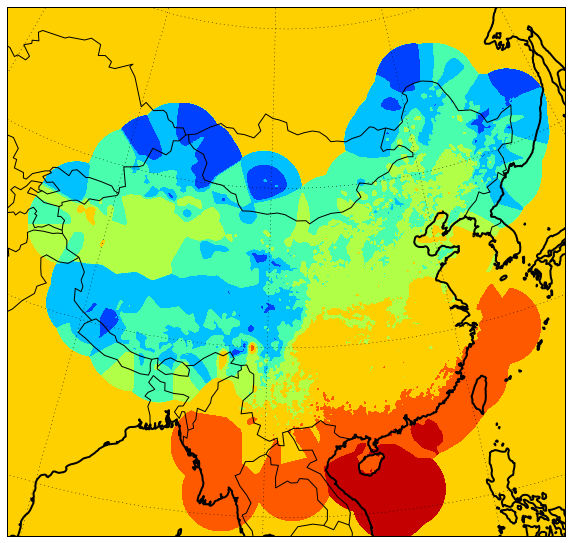

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=proj)
extents = (left, right, bottom, top)
ax.contourf(t, origin='lower', extent=extents, transform=proj)
ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(ccrs.cartopy.feature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m',facecolor='none'))
ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth='1', edgecolor='black')
ax.gridlines()
plt.show()